The Inflight Fulfillment service does not generate very good estimates for estimating when shortfalls will occur, nevermind the magnitude of the shortfall. 

Many of the input data to the Inflight service are stored as columns in `m_inflight_fulfillment`. If this data does carry good signal, we should be able to build simple ML models with better performance than Inflight's arithmetic approach.

In fact, building these models produced much better estimates, suggesting that flaws in Inflight occur in either the calculations which convert these data to estimates, the raw goods estimation/allocation process which is not accounted for in these data, potentially both, or some other externality.

# Imports, etc.

In [1]:
import datetime 
import os
import pandas as pd
import numpy as np

pd.set_option('display.max_rows',500)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from plotnine import *

In [3]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.inspection import permutation_importance

In [4]:
import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

# Shortfall vs Predicted Bounds
The mode of the prediction isn't correct often enough, but maybe the truth is in-bounds more often than we think?

In [5]:
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

qry = f"""
    select *,
    case when shortfall_lbs >= PREDICTED_SHORTFALL_LBS_Q10 and shortfall_lbs <= PREDICTED_SHORTFALL_LBS_Q90 then 1 else 0 end as in_bounds
    from predict.m_inflight_fulfillment
    where fact_date between '{START_DATE}' and '{END_DATE}'
    qualify rank() over (partition by fact_date, farm_id, component_id, prediction_days_ahead order by computed_at desc) = 1
"""

data_df = pd.read_sql(qry,conn)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


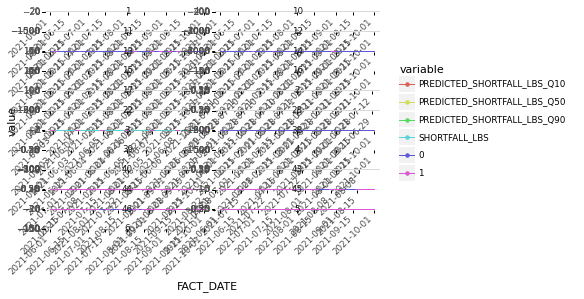

<ggplot: (357840939)>

In [6]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 2
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    
    .query('PREDICTION_DAYS_AHEAD == @N_PREDICTION_DAYS_AHEAD')
    .query('FARM_ID == 2')
    .assign(COMPONENT_ID_STR = lambda x: x['COMPONENT_ID'].astype(str))
    .assign(IN_BOUNDS_STR = lambda x: x['IN_BOUNDS'].astype(str))
    
    .filter(items=['FARM_ID','FACT_DATE','COMPONENT_ID_STR',
                   'IN_BOUNDS_STR',
                   'SHORTFALL_LBS',
                   'PREDICTED_SHORTFALL_LBS_Q10',
                   'PREDICTED_SHORTFALL_LBS_Q50',
                   'PREDICTED_SHORTFALL_LBS_Q90'])
    
    .pipe(lambda df:df.melt(id_vars=['FARM_ID',
                                     'FACT_DATE',
                                     'COMPONENT_ID_STR',
                                     'IN_BOUNDS_STR'],
                            value_vars=['SHORTFALL_LBS',
                                        'PREDICTED_SHORTFALL_LBS_Q10',
                                        'PREDICTED_SHORTFALL_LBS_Q50',
                                        'PREDICTED_SHORTFALL_LBS_Q90']))
    .assign(FACT_DATE = lambda x: pd.to_datetime(x['FACT_DATE']))

    
    .pipe(lambda df: ggplot(df, aes(x='FACT_DATE',y='value',color='variable'))
         + geom_line()
          + geom_point(aes(color='IN_BOUNDS_STR'))
#           + scale_color_manual(values={'1':'green','0':'red'})
         + facet_wrap('COMPONENT_ID_STR',scales='free',ncol=2)
         + theme(figure_size=(10,30), axis_text_x = element_text(hjust=1,rotation=45))
         )
)

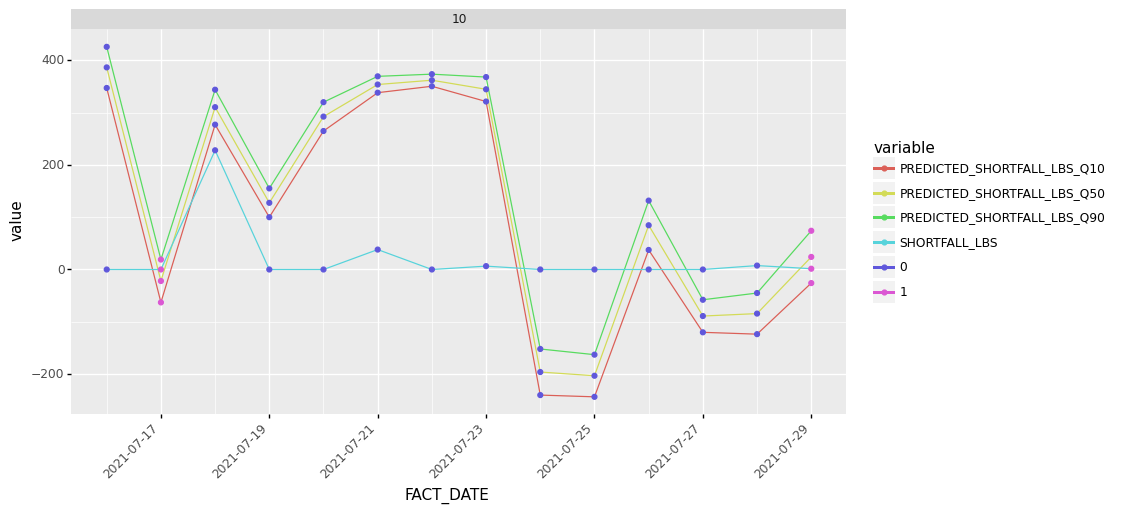

<ggplot: (363728348)>

In [7]:
DAYS_OBSERVED = 10
N_PREDICTION_DAYS_AHEAD = 2
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

(
    data_df
    
    .query('PREDICTION_DAYS_AHEAD == @N_PREDICTION_DAYS_AHEAD')
    .query('FARM_ID == 2')
    .assign(COMPONENT_ID_STR = lambda x: x['COMPONENT_ID'].astype(str))
    .assign(IN_BOUNDS_STR = lambda x: x['IN_BOUNDS'].astype(str))
    
    .filter(items=['FARM_ID','FACT_DATE','COMPONENT_ID_STR',
                   'IN_BOUNDS_STR',
                   'SHORTFALL_LBS',
                   'PREDICTED_SHORTFALL_LBS_Q10',
                   'PREDICTED_SHORTFALL_LBS_Q50',
                   'PREDICTED_SHORTFALL_LBS_Q90'])
    
    .pipe(lambda df:df.melt(id_vars=['FARM_ID',
                                     'FACT_DATE',
                                     'COMPONENT_ID_STR',
                                     'IN_BOUNDS_STR'],
                            value_vars=['SHORTFALL_LBS',
                                        'PREDICTED_SHORTFALL_LBS_Q10',
                                        'PREDICTED_SHORTFALL_LBS_Q50',
                                        'PREDICTED_SHORTFALL_LBS_Q90']))
    .assign(FACT_DATE = lambda x: pd.to_datetime(x['FACT_DATE']))

    .query('COMPONENT_ID_STR == "10"')
    .query('FACT_DATE > datetime.date(2021,7,15)')
    .query('FACT_DATE < datetime.date(2021,7,30)')
    
    .pipe(lambda df: ggplot(df, aes(x='FACT_DATE',y='value',color='variable'))
         + geom_line()
          + geom_point(aes(color='IN_BOUNDS_STR'))
#           + scale_color_manual(values={'1':'green','0':'red'})
         + facet_wrap('COMPONENT_ID_STR',scales='free',ncol=2)
         + theme(figure_size=(10,5), axis_text_x = element_text(hjust=1,rotation=45))
         )
)

Hm, we're not in bounds (fuschia) very often at all.

## Examine Basil's In-bounds Characteristics

In [8]:
# SKUs in play at F2 in our range

In [9]:
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'
FARM_ID = 2

qry = f"""
    select sku_id,
      min(delivery_scheduled_on) as min_date,
      max(delivery_scheduled_on) as max_date,
      sum(cases_allocated_count) as n_cases_allocated
    from warehouse.dm_line_items
    where farm_id in ({FARM_ID})
      and delivery_scheduled_on >= '{START_DATE}'
      and delivery_scheduled_on <= '{END_DATE}'
    group by sku_id
    order by n_cases_allocated desc
"""

df = pd.read_sql(qry,conn)

In [10]:
df

,SKU_ID,MIN_DATE,MAX_DATE,N_CASES_ALLOCATED
0,146,2021-06-20,2021-09-27,NaN
1,22,2021-06-07,2021-06-21,NaN
2,187,2021-06-04,2021-06-24,NaN
3,183,2021-06-07,2021-06-07,NaN
4,239,2021-07-06,2021-07-06,NaN
5,308,2021-08-26,2021-08-26,NaN
6,298,2021-07-22,2021-07-22,NaN
7,300,2021-07-22,2021-08-08,NaN
8,260,2021-06-25,2021-09-24,NaN
9,70,2021-07-19,2021-09-20,NaN


### How often is SKU 243 in bounds?

In [11]:
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'
FARM_ID = 2
SKU_ID = "243"
COMPONENT_ID = 15

In [12]:
qry = f"""
    select *,
      case when shortfall_lbs > 0 then 1 else 0 end as has_shortfall
    from predict.m_inflight_fulfillment
    where fact_date between '{START_DATE}' and '{END_DATE}'
      and is_latest_prediction = true
      and prediction_days_ahead = 0
    """

In [13]:
df = pd.read_sql(qry,conn)

In [14]:
df.shape

(4124, 31)

In [15]:
df.query('SHORTFALL_LBS > 0').shape

(1313, 31)

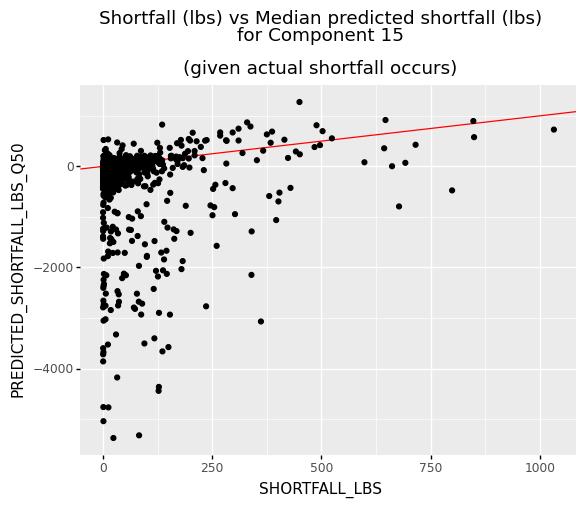

<ggplot: (364326235)>

In [16]:
(
    df.query('SHORTFALL_LBS > 0')
    
    .pipe(lambda df: ggplot(df, aes(x='SHORTFALL_LBS',y='PREDICTED_SHORTFALL_LBS_Q50'))          
          + geom_abline(intercept=0,slope=1, color='red')
          + geom_point()
          + ggtitle(f"Shortfall (lbs) vs Median predicted shortfall (lbs)\nfor Component {COMPONENT_ID}\n\n(given actual shortfall occurs)")
         )
)

### In-bounds rate

In [17]:
(
    df.assign(in_bounds = lambda x: x['IS_WITHIN_BOUNDS'].astype(int))
    .query('SHORTFALL_LBS > 0')
    .agg(in_bounds_rate = pd.NamedAgg('in_bounds','mean'))
)

,in_bounds
in_bounds_rate,0.067784


### Error rate vs bound width
Does the error rate correspond with the size of the error bound?

In [18]:
(
    df.assign(bounds_width = lambda x: x['PREDICTED_SHORTFALL_LBS_Q90'] - x['PREDICTED_SHORTFALL_LBS_Q10'])
    .assign(in_bounds = lambda x: x['IS_WITHIN_BOUNDS'].astype(int))
    .assign(bounds_width_q = lambda x: pd.qcut(x['bounds_width'],10, duplicates='drop'))
    
    .groupby('bounds_width_q')
    .agg(in_bounds_rate = pd.NamedAgg('in_bounds','mean'))
)

,in_bounds_rate
bounds_width_q,
"(-0.001, 5.375]",0.397187
"(5.375, 10.358]",0.080097
"(10.358, 19.024]",0.053269
"(19.024, 28.046]",0.024272
"(28.046, 45.155]",0.043689
"(45.155, 1285.83]",0.072639


This stands to reason - the smaller the bound, the higher the condfidence

# Models

## Data Prep

In [19]:
df.columns

Index(['FARM_ID', 'FACT_DATE', 'REFERENCE_DATE', 'COMPONENT_ID',
       'COMPONENT_NAME', 'CASE_INVENTORY_LBS', 'BIN_INVENTORY_LBS',
       'RECENT_HARVEST_TO_PACK_PCT', 'BIN_INVENTORY_PACKED_ESTIMATION_LBS',
       'PACKED_LBS', 'INCOMING_TRANSSHIP_LBS', 'OUTGOING_TRANSSHIP_LBS',
       'ANTICIPATED_SUPPLY_LBS', 'DEMAND_LBS', 'ALLOCATED_LBS',
       'ANTICIPATED_SHORTFALL_LBS', 'SHORTFALL_LBS',
       'PREDICTED_SHORTFALL_LBS_Q10', 'PREDICTED_SHORTFALL_LBS_Q50',
       'PREDICTED_SHORTFALL_LBS_Q90', 'SHORTFALL_PROBABILITY', 'COMPUTED_AT',
       'COMPUTED_AT_LOCAL', 'PREDICTION_DAYS_AHEAD', 'CODE_VERSION', 'GIT_SHA',
       'IS_BACKFILL', 'MESSAGE_ID', 'IS_WITHIN_BOUNDS', 'IS_LATEST_PREDICTION',
       'HAS_SHORTFALL'],
      dtype='object')

In [20]:
keep_columns = [
    'FARM_ID',
    'COMPONENT_ID',
    'CASE_INVENTORY_LBS',
    'BIN_INVENTORY_LBS',
    'RECENT_HARVEST_TO_PACK_PCT',
    'BIN_INVENTORY_PACKED_ESTIMATION_LBS',
    'PACKED_LBS',
    'INCOMING_TRANSSHIP_LBS',
    'OUTGOING_TRANSSHIP_LBS',
    'DEMAND_LBS',
    'SUPPLY_LBS',
    'SHORTFALL_PROBABILITY',
    'ANTICIPATED_SUPPLY_LBS'
]

X = (
    df.drop([x for x in df.columns if x not in keep_columns], axis=1)
    
    .pipe(lambda df: pd.concat([
        df, 
        pd.get_dummies(df['FARM_ID'], prefix='FARM_ID_')],
    axis=1))
    .drop('FARM_ID', axis=1)
    
    .pipe(lambda df: pd.concat([
        df, 
        pd.get_dummies(df['COMPONENT_ID'], prefix='COMPONENT_ID_')],
    axis=1))
    .drop('COMPONENT_ID', axis=1)
    
    .fillna(0)
    
)
y = df['HAS_SHORTFALL']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1138)

## Inflight Performance

In [22]:
auc_score = roc_auc_score(y_true=y_test,y_score=X_test['SHORTFALL_PROBABILITY'])

auc_score

0.5066889517793911

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, X_test['SHORTFALL_PROBABILITY'])

In [24]:
inflight_auc = pd.DataFrame({'fpr':fpr,'tpr':tpr}).assign(source='inflight')

## SGDClassifier 

In [25]:
param_grid = {
    'alpha':[0.0001,0.1,0.5,1,10,100],
    'l1_ratio':[0,0.1,0.5,0.9,1.0],    
}
clf = SGDClassifier(learning_rate='adaptive',eta0=1.0, penalty='elasticnet',loss='log_loss')
gscv = GridSearchCV(clf, param_grid, n_jobs=4, refit=True)

In [26]:
fitted = gscv.fit(X_train.drop('SHORTFALL_PROBABILITY',axis=1),y_train)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed P

In [27]:
y_pred = fitted.predict(X_test.drop('SHORTFALL_PROBABILITY',axis=1))

y_proba = fitted.predict_proba(X_test.drop('SHORTFALL_PROBABILITY',axis=1))

In [28]:
auc_score = roc_auc_score(y_true=y_test,y_score=y_proba[:,1])

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])

In [30]:
sgd_logistic_auc = pd.DataFrame({'fpr':fpr,'tpr':tpr}).assign(source='sgd_logistic')

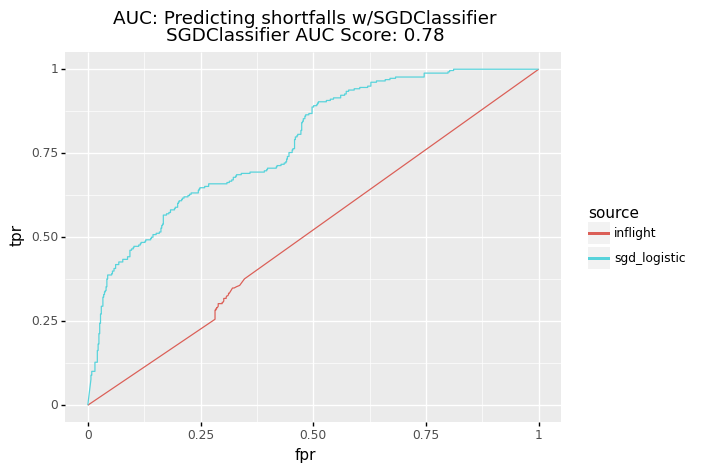

<ggplot: (364579172)>

In [31]:
(
    pd.concat([inflight_auc, sgd_logistic_auc],axis=0)
    .pipe(lambda df:
        ggplot(df, aes(x='fpr',y='tpr', color='source')) 
        + geom_line()
        + ggtitle(f"AUC: Predicting shortfalls w/SGDClassifier\nSGDClassifier AUC Score: {auc_score:.2f}")
         )
)

In [32]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[544,  23],
       [167,  91]])

In [33]:
pd.DataFrame({'y_true':y_test,'y_pred':y_pred}).groupby(['y_true','y_pred']).size()

y_true  y_pred
0       0         544
        1          23
1       0         167
        1          91
dtype: int64

## RandomForestClassifier

In [34]:
param_grid = {
    'max_depth': [3,5,10,12],
    'min_samples_leaf': [1,3,5]
}

rf_clf = RandomForestClassifier()
rf_gscv = GridSearchCV(rf_clf, param_grid, n_jobs=4, refit=True)

In [35]:
rf_fitted = rf_gscv.fit(X_train.drop('SHORTFALL_PROBABILITY',axis=1),y_train)

In [36]:
rf_fitted.best_params_

{'max_depth': 12, 'min_samples_leaf': 1}

In [37]:
y_pred = rf_fitted.predict(X_test.drop('SHORTFALL_PROBABILITY',axis=1))

In [38]:
y_proba = rf_fitted.predict_proba(X_test.drop('SHORTFALL_PROBABILITY',axis=1))

In [39]:
auc_score = roc_auc_score(y_true=y_test,y_score=y_proba[:,1])

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])

In [41]:
rf_auc = pd.DataFrame({'fpr':fpr,'tpr':tpr}).assign(source='rf')

In [42]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[511,  56],
       [ 50, 208]])

In [43]:
pd.DataFrame({'y_true':y_test,'y_pred':y_pred}).groupby(['y_true','y_pred']).size()

y_true  y_pred
0       0         511
        1          56
1       0          50
        1         208
dtype: int64

## Classifier Roundup

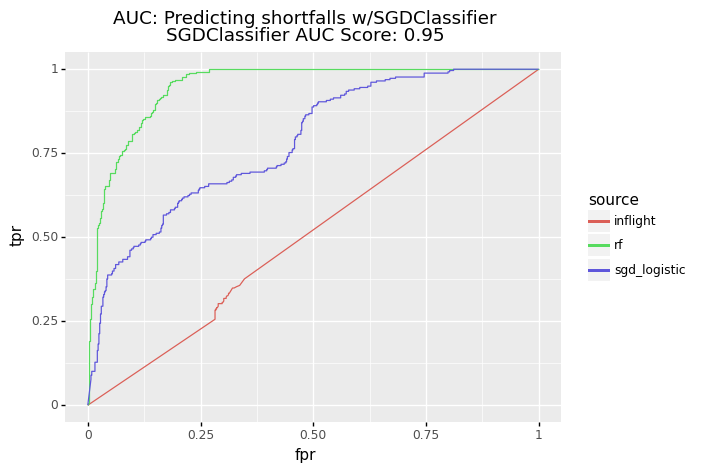

<ggplot: (364386036)>

In [44]:
(
    pd.concat([inflight_auc, sgd_logistic_auc, rf_auc],axis=0)
    .pipe(lambda df:
        ggplot(df, aes(x='fpr',y='tpr', color='source')) 
        + geom_line()
        + ggtitle(f"AUC: Predicting shortfalls w/SGDClassifier\nSGDClassifier AUC Score: {auc_score:.2f}")
         )
)

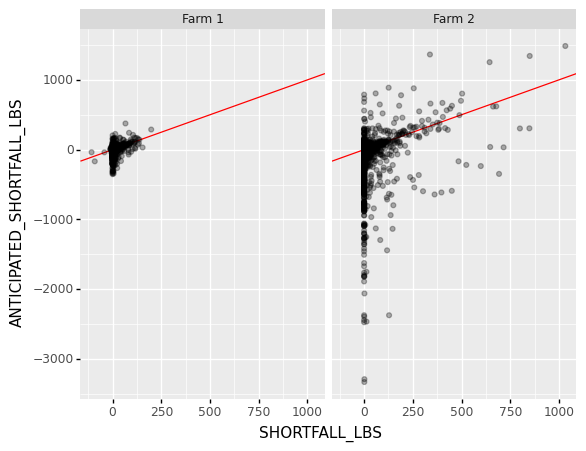

<ggplot: (365716854)>

In [45]:
(
    df
    .assign(FARM_ID_STR = lambda x: 'Farm '+x['FARM_ID'].astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='SHORTFALL_LBS',y='ANTICIPATED_SHORTFALL_LBS'))
          + geom_abline(intercept=0,slope=1,color='red')
          + geom_point(alpha=0.3)
          + facet_wrap('FARM_ID_STR')
         )
)

## Classifier Feature Importances

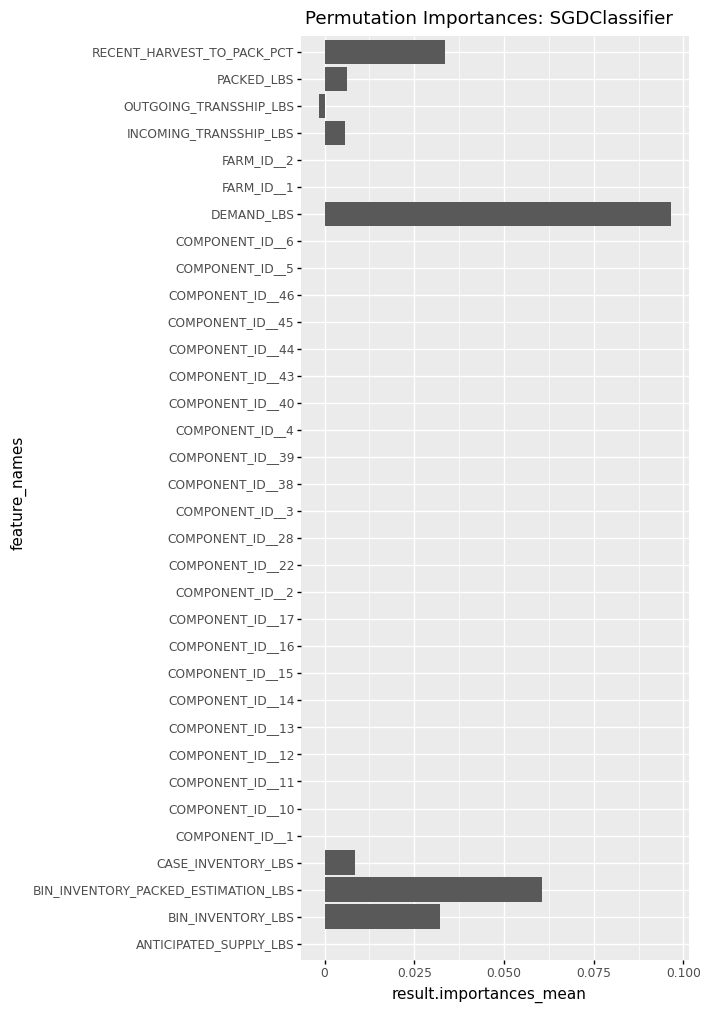

<ggplot: (357800229)>

In [46]:
result = permutation_importance(fitted,X_test.drop('SHORTFALL_PROBABILITY',axis=1), y_test, n_repeats=10)


(
    pd.DataFrame({
        'result.importances_mean':result.importances_mean, 
        'feature_names':X_test.drop('SHORTFALL_PROBABILITY',axis=1).columns})
    .sort_values('result.importances_mean')
    
    .pipe(lambda df: ggplot(df, aes(x='feature_names',y='result.importances_mean'))
         + geom_bar(stat='identity')
         + coord_flip()
         + theme(figure_size=(5,12))
         + ggtitle("Permutation Importances: SGDClassifier")
         )
)

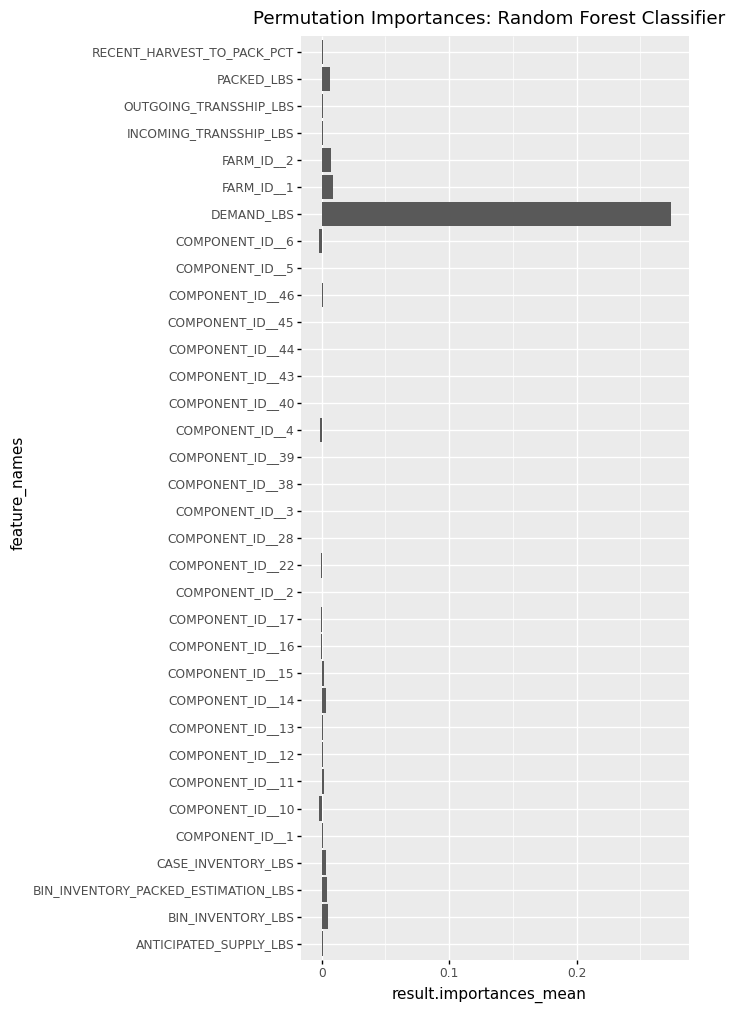

<ggplot: (358590278)>

In [47]:
result = permutation_importance(rf_fitted,X_test.drop('SHORTFALL_PROBABILITY',axis=1), y_test, n_repeats=10)


(
    pd.DataFrame({
        'result.importances_mean':result.importances_mean, 
        'feature_names':X_test.drop('SHORTFALL_PROBABILITY',axis=1).columns})
    .sort_values('result.importances_mean')
    
    .pipe(lambda df: ggplot(df, aes(x='feature_names',y='result.importances_mean'))
         + geom_bar(stat='identity')
         + coord_flip()
         + theme(figure_size=(5,12))
         + ggtitle("Permutation Importances: Random Forest Classifier")
         )
)

## RandomForestRegressor

In [60]:
keep_columns = [
    'FARM_ID',
    'COMPONENT_ID',
    'CASE_INVENTORY_LBS',
    'BIN_INVENTORY_LBS',
    'RECENT_HARVEST_TO_PACK_PCT',
    'BIN_INVENTORY_PACKED_ESTIMATION_LBS',
    'PACKED_LBS',
    'INCOMING_TRANSSHIP_LBS',
    'OUTGOING_TRANSSHIP_LBS',
    'DEMAND_LBS',
    'SUPPLY_LBS',
    'SHORTFALL_PROBABILITY',
    'ANTICIPATED_SUPPLY_LBS'
]

X = (
#     df.drop([x for x in df.columns if x not in keep_columns], axis=1)
    df
    .pipe(lambda df: pd.concat([
        df, 
        pd.get_dummies(df['FARM_ID'], prefix='FARM_ID_')],
    axis=1))
#     .drop('FARM_ID', axis=1)
    
    .pipe(lambda df: pd.concat([
        df, 
        pd.get_dummies(df['COMPONENT_ID'], prefix='COMPONENT_ID_')],
    axis=1))
#     .drop('COMPONENT_ID', axis=1)
    
    .fillna(0)
    
)
y = df['SHORTFALL_LBS']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1138)

In [62]:
param_grid = {
    'max_depth': [3,5,10,12],
    'min_samples_leaf': [1,3,5]
}

rf_reg = RandomForestRegressor()
rf_gscv = GridSearchCV(rf_reg, param_grid, n_jobs=4, refit=True)

In [63]:
fit_columns = [x for x in X_train.columns if (x in keep_columns or 'FARM_ID_' in x or 'COMPONENT_ID_' in x)]

In [64]:
rf_fitted = rf_gscv.fit(X_train[fit_columns],y_train)

In [65]:
y_pred = rf_fitted.predict(X_test[fit_columns])

In [66]:
X_test

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,COMPONENT_ID__17,COMPONENT_ID__22,COMPONENT_ID__28,COMPONENT_ID__38,COMPONENT_ID__39,COMPONENT_ID__40,COMPONENT_ID__43,COMPONENT_ID__44,COMPONENT_ID__45,COMPONENT_ID__46
2654,2,2021-06-10,2021-06-10,38,Mizuna,54.000,287.407332,74.726774,214.770228,190.430763,...,0,0,0,1,0,0,0,0,0,0
95,1,2021-07-18,2021-07-18,13,Mustard,1.350,8.615672,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
336,1,2021-06-09,2021-06-09,6,Arugula,24.375,7.932239,65.024516,5.157900,4.500000,...,0,0,0,0,0,0,0,0,0,0
1290,1,2021-08-06,2021-08-06,40,Red Mizuna,34.950,10.793841,86.904839,9.380370,0.000000,...,0,0,0,0,0,1,0,0,0,0
3250,2,2021-07-18,2021-07-18,4,Baby Kale,154.020,248.230392,76.458065,189.792153,123.698655,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826,1,2021-06-04,2021-06-04,6,Arugula,30.375,32.222791,63.843226,20.572069,7.500000,...,0,0,0,0,0,0,0,0,0,0
2945,2,2021-09-28,2021-09-28,4,Baby Kale,332.865,186.183472,86.374839,160.815673,203.308270,...,0,0,0,0,0,0,0,0,0,0
142,2,2021-07-01,2021-07-01,22,Chard,0.000,265.383134,76.249032,202.352072,146.625078,...,0,1,0,0,0,0,0,0,0,0
2363,2,2021-08-25,2021-08-25,38,Mizuna,0.000,581.593150,78.447742,456.246693,253.825775,...,0,0,0,1,0,0,0,0,0,0


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


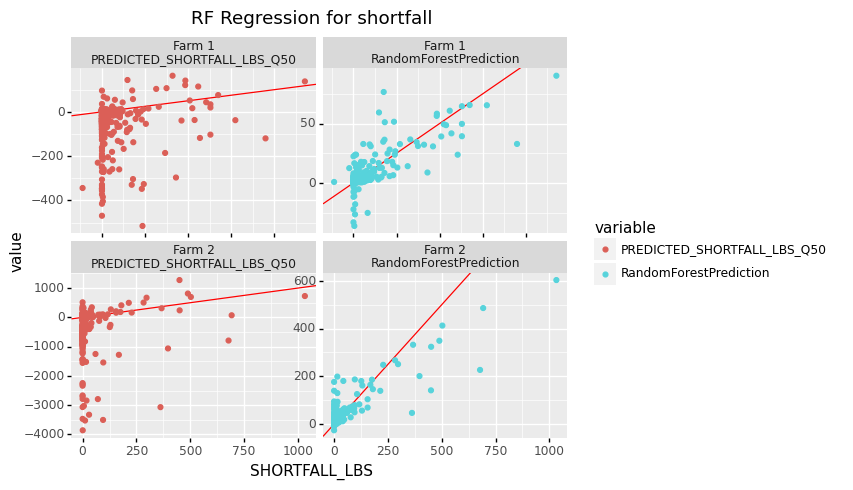

<ggplot: (361201318)>

In [67]:
(
    X_test[['FARM_ID','SHORTFALL_LBS','PREDICTED_SHORTFALL_LBS_Q50']]
    .assign(RandomForestPrediction = y_pred)
    
    .pipe(lambda df: pd.melt(df, id_vars=['FARM_ID','SHORTFALL_LBS']))
    
    .assign(FARM_ID_STR = lambda x: 'Farm ' + x['FARM_ID'].astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='SHORTFALL_LBS',y='value',color='variable'))
         + geom_abline(intercept=0,slope=1,color='red')
         + geom_point()
         + facet_wrap(['FARM_ID_STR','variable'],scales='free')
         + ggtitle("RF Regression for shortfall")
         )
)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


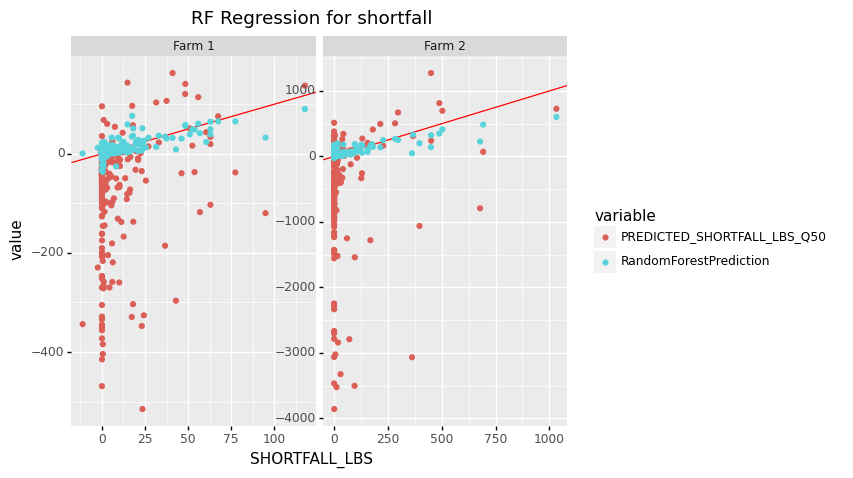

<ggplot: (362015431)>

In [68]:
(
    X_test[['FARM_ID','SHORTFALL_LBS','PREDICTED_SHORTFALL_LBS_Q50']]
    .assign(RandomForestPrediction = y_pred)
    
    .pipe(lambda df: pd.melt(df, id_vars=['FARM_ID','SHORTFALL_LBS']))
    
    .assign(FARM_ID_STR = lambda x: 'Farm ' + x['FARM_ID'].astype(str))
    
    .pipe(lambda df: ggplot(df, aes(x='SHORTFALL_LBS',y='value',color='variable'))
         + geom_abline(intercept=0,slope=1,color='red')
         + geom_point()
         + facet_wrap(['FARM_ID_STR'],scales='free')
         + ggtitle("RF Regression for shortfall")
         )
)

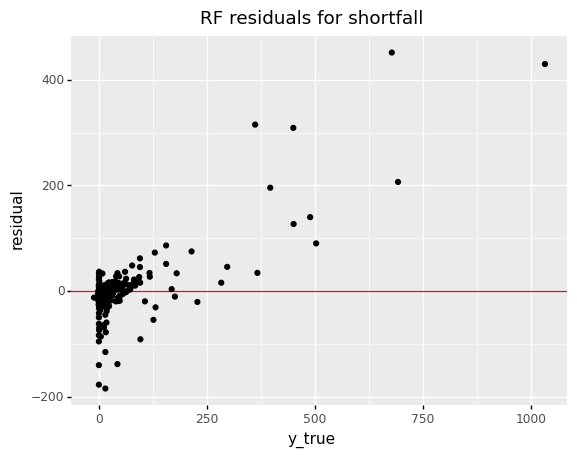

<ggplot: (362581998)>

In [69]:
(
    pd.DataFrame({'y_true':y_test,'y_pred':y_pred})
    .assign(residual = lambda x: x['y_true'] - x['y_pred'])
    
    .pipe(lambda df: ggplot(df, aes(x='y_true',y='residual'))
         + geom_hline(yintercept=0, color='red')
         + geom_point()
         + ggtitle("RF residuals for shortfall")
         )
)

## RF importances

In [70]:
result = permutation_importance(rf_fitted,X_test[fit_columns], y_test, n_repeats=10)


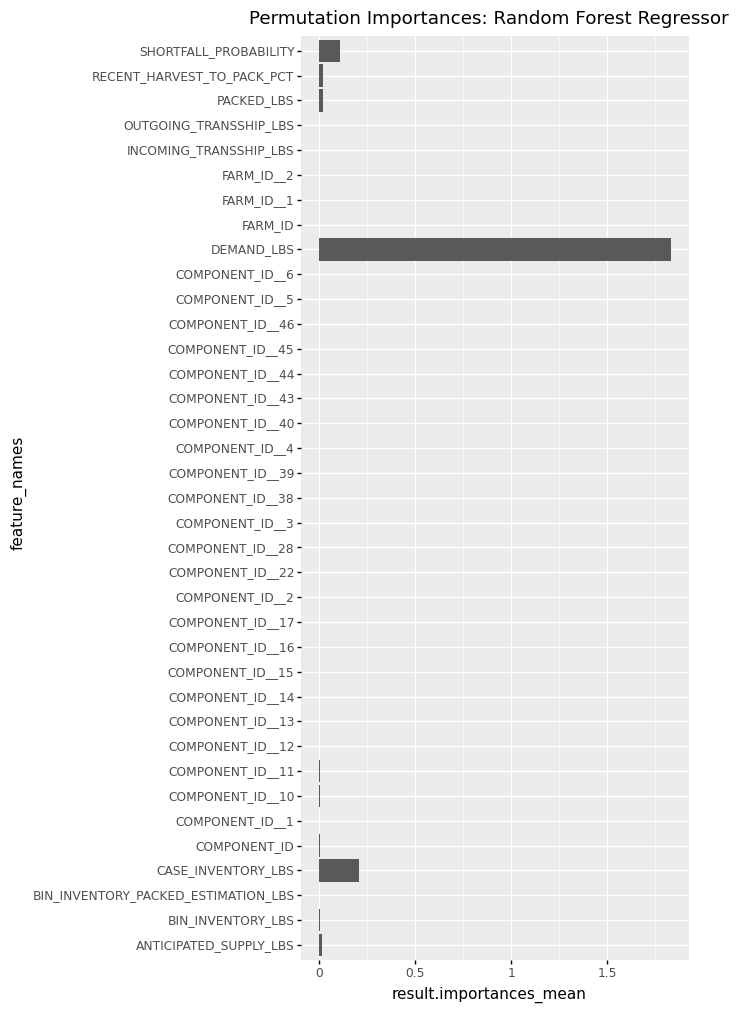

<ggplot: (362765990)>

In [71]:
(
    pd.DataFrame({
        'result.importances_mean':result.importances_mean, 
        'feature_names':X_test[fit_columns].columns})
    .sort_values('result.importances_mean')
    
    .pipe(lambda df: ggplot(df, aes(x='feature_names',y='result.importances_mean'))
         + geom_bar(stat='identity')
         + coord_flip()
         + theme(figure_size=(5,12))
         + ggtitle("Permutation Importances: Random Forest Regressor")
         )
)